# AI Exam

Consider the following environment:

<img src="images/road_env.jpg" style="zoom: 40%;"/>

The agent starts in cell $(0, 0)$ and must reach the goal in cell $(8,6)$. The agent can move in the four directions (except when a wall is present), and for each step taken the agent receives a negative reward.
In cells representing roads with intersections, the agent must wait for the traffic light to turn green before proceeding. At busy intersections (indicated by two traffic lights in the same cell), the agent will have to wait a long time to cross the intersection. This means that if the agent tries to move to another cell, the action may not succeed, causing the agent to remain in the same cell for an unknown amount of time.

Assume that you do not have access to the motion model and to reward and that the problem is undiscounted, find a solution for the environment reported above with a suitable algorithm of your choice, motivating your choice.

In [1]:
import os, sys 

module_path = os.path.abspath(os.path.join('tools'))
if module_path not in sys.path:
    sys.path.append(module_path)


import gym, envs
from utils.ai_lab_functions import *
import numpy as np
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

env_name = 'RoadEnv-v0'
env = gym.make(env_name)

env.render()

print("\nActions encoding: ", env.actions)

# Remember that you can know the type of a cell whenever you need by accessing the grid element of the environment:
print("Cell type of start state: ",env.grid[env.startstate])
print("Cell type of goal state: ",env.grid[env.goalstate])
state = 15 # a very busy intersection
print(f"Cell type of cell {env.state_to_pos(state)}: ",env.grid[state])
state = 10 # a less busy intersection
print(f"Cell type of cell {env.state_to_pos(state)}: ",env.grid[state])

[['S' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['W' 'Tl' 'W' 'W' 'W' 'W' 'W' 'W' 'R']
 ['W' 'Tl' 'W' 'W' 'W' 'W' 'W' 'W' 'R']
 ['W' 'Tl' 'W' 'R' 'R' 'R' 'R' 'R' 'R']
 ['W' 'Tl' 'W' 'R' 'W' 'W' 'W' 'W' 'W']
 ['W' 'Tl' 'W' 'R' 'W' 'W' 'W' 'W' 'W']
 ['W' 'Tl' 'W' 'R' 'W' 'W' 'W' 'W' 'W']
 ['W' 'Tl' 'W' 'R' 'W' 'W' 'W' 'W' 'W']
 ['W' 'R' 'R' 'R' 'R' 'R' 'G' 'W' 'W']]

Actions encoding:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Cell type of start state:  S
Cell type of goal state:  G
Cell type of cell (1, 6):  W
Cell type of cell (1, 1):  Tl


In [2]:
def epsilon_greedy(q, state, epsilon):
    """
    Epsilon-greedy action selection function
    
    Args:
        q: q table
        state: agent's current state
        epsilon: epsilon parameter
    
    Returns:
        action id
    """
    if np.random.random() < epsilon: #enters the if only if the random number is less than epsilon (i.e., with probability  epsilon)
        return np.random.choice(q.shape[1]) #the size of first dimension of q is number of states, the second is number of actions 
    return q[state].argmax() #q[state] is a vector of q-values indexed by actions

def softmax(q, state, temp):
    """
    Softmax action selection function
    
    Args:
    q: q table
    state: agent's current state
    temp: temperature parameter
    
    Returns:
        action id
    """
    e = np.exp(q[state] / temp) #a vector indexed by action where each value is e^(q(s,a)/T)
    return np.random.choice(q.shape[1], p=e / e.sum()) # choose an action with probability e^(q(s,a)/T)/sum_{a'} e^(q(s,a')/T)  

In [3]:
def q_learning(environment, episodes= 500, alpha = 0.3, gamma = 0.9, expl_func = epsilon_greedy, expl_param = 0.1):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon or T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)
    
    for i in range(episodes):
        state = environment.reset()
        length = 0
        tot_rew = 0
        while True:
            action = expl_func(q, state, expl_param)
            next_state, reward, done, _ = environment.step(action)
            q[state, action] += alpha * (reward + gamma * q[next_state].max() - q[state, action])
            state = next_state
            length += 1
            tot_rew += reward
            if done:
                break
        rews[i] = tot_rew
        lengths[i] = length
        
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

In [4]:
#IMPLEMENT THIS FUNCTION, YOU CAN CHANGE THE PARAMETERS FOR THE FUNCTION IF THIS IS USEFUL

def sarsa(environment,expl_func=softmax, episodes=500, alpha=.3, gamma=.9, expl_param=.1):
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)
    
    for i in range(episodes):
        state = environment.reset()
        length = 0
        tot_rew = 0
        action = expl_func(q, state, expl_param)
        while True:
            next_state, reward, done, _ = environment.step(action)
            next_action = expl_func(q, next_state, expl_param)
            q[state, action] += alpha * (reward + gamma * q[next_state, next_action] - q[state, action])
            state = next_state
            action = next_action
            length += 1
            tot_rew += reward
            if done:
                break
        rews[i] = tot_rew
        lengths[i] = length
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

In [5]:


def iter_val(environment, discount = 1, maxiters = 500, max_error = 1e-3): 

    delta = 0 # maximum change in the utility o any state in an iteration
    #
    U_1 = np.zeros(environment.observation_space.n)
    for i in range(maxiters):
        U = U_1.copy()
        for s in range(environment.observation_space.n):
            somm = np.zeros(env.action_space.n)
            for a in range(env.action_space.n):
                for s_1 in range(environment.observation_space.n):
                    somm[a] += environment.T[s, a, s_1] * (environment.RS[s] + discount * U[s_1])
            U_1[s] = np.max(somm)
            if np.max(np.abs(U - U_1)) < max_error:
                break
    #
    return values_to_policy(np.asarray(U), env) # automatically convert the value matrix U to a policy

Execution time: 1.8156s
Iterative Value Iteration solution: 
[['R' 'D' 'L' 'L' 'R' 'U' 'D' 'D' 'R']
 ['L' 'D' 'L' 'L' 'L' 'L' 'L' 'L' 'U']
 ['L' 'D' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'R' 'R' 'U' 'D' 'R' 'R']
 ['L' 'D' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'R' 'R' 'R' 'R' 'R' 'L' 'L' 'L']]
Execution time: 2.8987s
Iterative Value Iteration solution: 
[['R' 'D' 'L' 'L' 'L' 'L' 'R' 'R' 'R']
 ['L' 'D' 'L' 'L' 'L' 'L' 'L' 'L' 'D']
 ['L' 'D' 'L' 'L' 'L' 'L' 'L' 'L' 'D']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'L' 'L']
 ['L' 'R' 'R' 'R' 'R' 'R' 'L' 'L' 'L']]


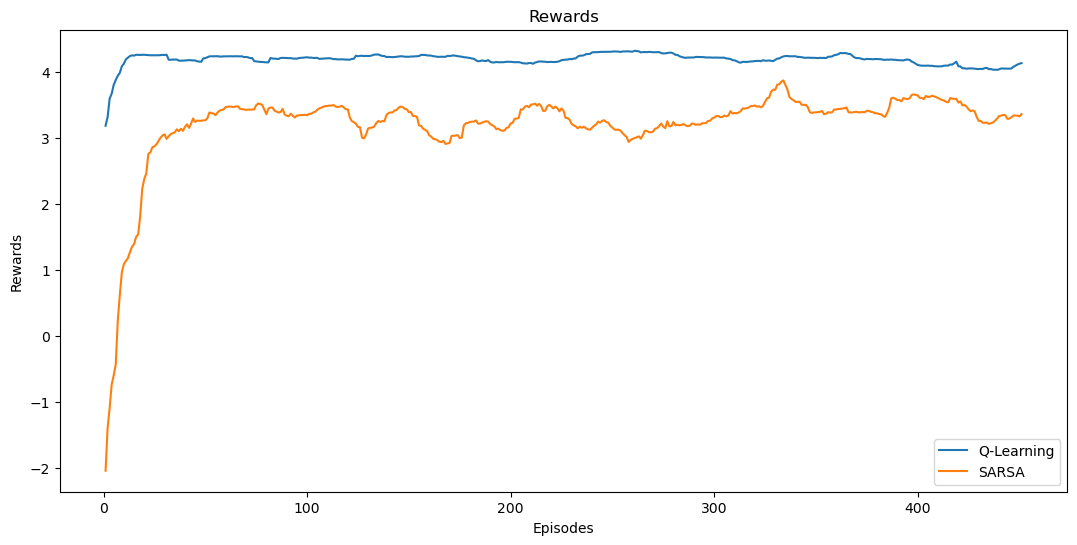

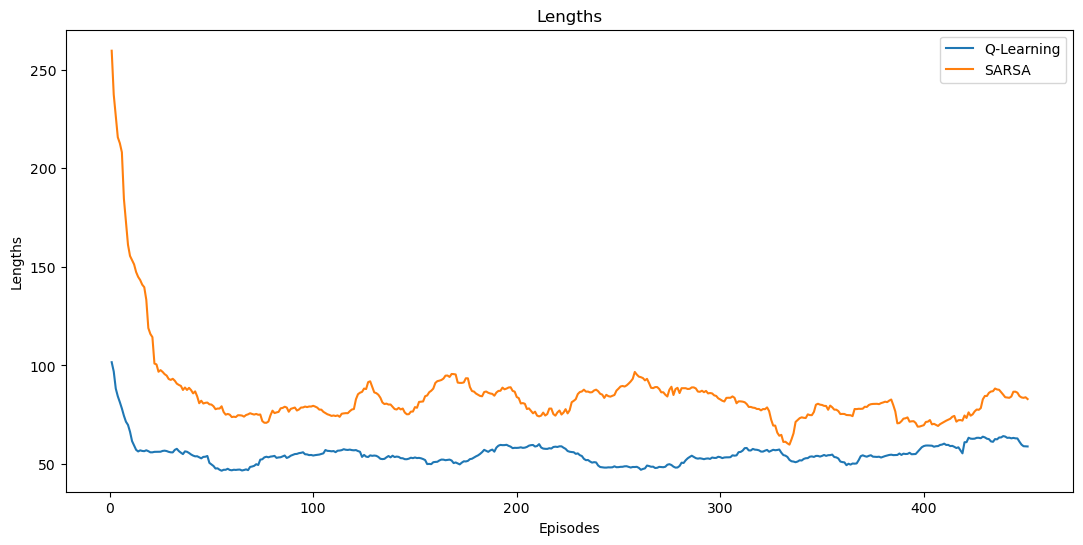

In [6]:
#t = timer()
#policy, rews, lengths = iter_val(env)
#print(f"Execution time: {round(timer() - t, 4)}s") 
#solution_render = np.vectorize(env.actions.get)(policy.reshape(env.shape))
#print("Iterative Value Iteration solution: ")
#print(solution_render)


window = 50  # Rolling window
rewser = []
lenser = []

t = timer()
_, rews, lengths = q_learning(env)
#_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
print("Execution time: {0}s".format(round(timer() - t, 4)))
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "ls": "-", "label": "Q-Learning"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "ls": "-", "label": "Q-Learning"})
solution_render = np.vectorize(env.actions.get)(_.reshape(env.shape))
print("Iterative Value Iteration solution: ")
print(solution_render)

# SARSA
t = timer()
_, rews, lengths = sarsa(env)
#_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
print("Execution time: {0}s".format(round(timer() - t, 4)))

solution_render = np.vectorize(env.actions.get)(_.reshape(env.shape))
print("Iterative Value Iteration solution: ")
print(solution_render)
#_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "label": "SARSA"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "SARSA"})

#print("Execution time: {0}s".format(round(timer() - t, 4)))

plot(rewser, "Rewards", "Episodes", "Rewards")
plot(lenser, "Lengths", "Episodes", "Lengths")